# Diversity

For this experiment, we will want to find multiple different levels with the same difficulty.

In [1]:
import matplotlib.pyplot as plt
import torch
from IPython.core.display import clear_output
from torch.nn import LeakyReLU, functional as F
from torch.optim import Adam

from evaluators import DirectEvaluator
from framework import SeededGenerator
from shared_parameters import *

torch.set_printoptions(linewidth=120, sci_mode=False)

Here our generator NN will define the *offset* from the point in space, that is
also fed in as an input to the generator.

Preview of the embedding space and difficulties

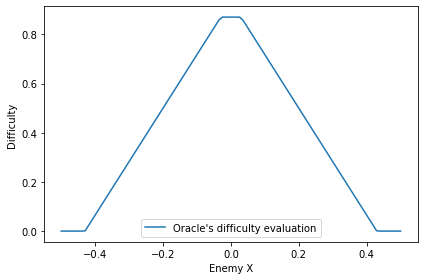

In [2]:
oracle = DirectEvaluator(connector_length, max_angle, enemy_radius, bob_radius)
enemy_x = np.linspace(enemy_x_min, enemy_x_max, 100)
evaluation = oracle(enemy_x)

axs = plt.subplot()

axs.plot(enemy_x, evaluation)
axs.set_xlabel("Enemy X")
axs.set_ylabel("Difficulty")
axs.legend(["Oracle's difficulty evaluation"])
plt.tight_layout()

plt.show()

We see that for the same difficulty, there exist several levels, that have the same difficulty.
However, with the way we've set up our generators, they can only output a single level for the given difficulty.

Now let's give the generator two inputs: the input difficulty $d_{in}$, as well the seed $\epsilon$

    Let's try with the simultaneous learning first

It.: 2858, difficulty_loss=0.03063 offsets_loss=0.15843
Parameters:
tensor([[ 0.6510, -0.0526],
        [-0.2456,  0.6405],
        [ 0.2131, -0.0312],
        [-0.4209, -0.0671],
        [-0.1851, -5.2646],
        [ 0.8006, -1.6215],
        [ 0.0173, -0.0256],
        [ 0.5480,  1.5165]])
tensor([-0.7287,  0.6454, -0.2378, -0.0375,  0.1183, -0.1742, -0.1292, -0.1425])
tensor([[     0.1959,     -0.0108,      0.4128,     -0.2010,     -0.2665,      0.4917,      0.0355,     -0.2540],
        [    -0.5098,      0.3678,      0.0180,      0.0838,      0.3712,     -0.8033,     -0.2200,      0.4015],
        [    -0.0640,     -0.3257,     -0.1002,      0.1542,      0.4523,      0.4795,     -0.1538,      0.2203],
        [     0.1145,     -0.0023,     -0.4125,     -0.0008,      0.1168,     -0.3990,     -0.3851,      0.1564],
        [    -0.4142,     -0.2206,     -0.2273,      0.1123,      0.0114,      0.0137,      0.0737,      0.1763],
        [     0.4856,     -0.2379,     -0.0438,     -0.3

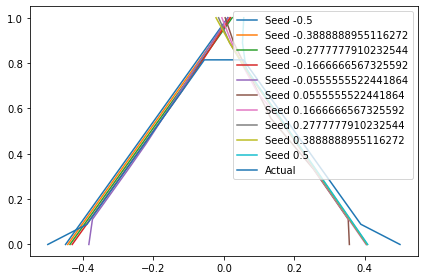

In [13]:
oracle = DirectEvaluator(connector_length, max_angle, enemy_radius, bob_radius)

bounds = torch.tensor([[enemy_x_min, enemy_x_max]])
generator = SeededGenerator(bounds, hidden=[8, 8], activation=LeakyReLU(), optimizer_class=Adam, lr=0.01,
                            loss_function=F.l1_loss)
num_difficulties = 100
num_seeds = 100

# Our dataset of [difficulty, seed] inputs
difficulties = torch.linspace(0, 1, num_difficulties)
seeds = torch.linspace(enemy_x_min, enemy_x_max, num_seeds)
dataset = torch.cartesian_prod(difficulties, seeds)

iteration = 0
loss_evaluator = float("inf")


def iterate(verbose=False):
    global dataset, iteration

    # Sample from the dataset
    indices = torch.randperm(dataset.shape[0])[:15]
    sample = dataset[indices]

    # Generate levels
    generated_levels = generator(sample)

    # Estimate the difficulty
    d_out = oracle(generated_levels)

    # Train the generator on the evaluated difficulty
    loss_difficulty, loss_offsets = generator.update(d_out)

    iteration += 1

    if verbose:
        clear_output(wait=True)
        print(f"It.: {iteration}, "
              f"difficulty_loss={loss_difficulty.item():.5f} "
              f"offsets_loss={loss_offsets.item():.5f}")

        print("Parameters:")
        for p in generator.parameters():
            print(p.data)

        r_difficulties = torch.linspace(0, 1, 10)
        r_seeds = torch.linspace(enemy_x_min, enemy_x_max, 10)
        r_dataset = torch.cartesian_prod(r_difficulties, r_seeds)

        generated_states = generator(r_dataset).detach()

        d_out = oracle(generated_states)

        collected = torch.hstack((r_dataset, generated_states, d_out))

        fix, ax = plt.subplots()

        for i in range(r_seeds.shape[0]):
            selected = collected[i::r_difficulties.shape[0], :]
            ds, xs = selected[:, 0], selected[:, 2]
            ax.plot(xs, ds)

        ax.plot(r_seeds, oracle(r_seeds))

        ax.legend([*[f"Seed {seed}" for seed in r_seeds], "Actual"])
        plt.tight_layout()

        plt.show()


iterate()

try:
    for _ in range(100):
        for _ in range(50):
            iterate()
        iterate(True)
except KeyboardInterrupt:
    pass

iterate(True)

In [ ]:
try:
    for _ in range(100):
        for _ in range(50):
            iterate()
        iterate(True)
except KeyboardInterrupt:
    pass

iterate(True)